In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns

In [2]:
pd.options.display.max_rows = 4000
pd.options.display.max_columns = 4000

In [3]:
df = pd.read_csv("sap_storing_data_hu_project.csv")

C:\Users\cc\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,11,19,21,24,25,27,32,33,36,37,38,39,40,46,47,48,49,51,53,55,56,60,73,75,78,80,82,83,86,87,91,95,99,102,103,104,107,108,109,110,111,112,113,116,118,119,120,121,122,123,124,129) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


We hebben de categoriale features en numerieke features gesplits in 2 dataframes. dit doen we zodat het makkelijker is om vergelijkingen te maken

In [6]:
numeriek = df.select_dtypes(include=np.number)
categoriaal_df = df.select_dtypes(include=["object"])

We hebben uiteindelijk alle hoge en lage outliers van het numerieke dataframe uitgehaalt

## Outliers eruit

In [9]:
def remove_outliers(df):
    for item in df:
        quantile_1 = df[item].quantile(0.25)
        quantile_3 = df[item].quantile(0.75)
        iqr = quantile_3 - quantile_1

        outlier_lower_value = quantile_1 - 3*iqr
        outlier_high_value = quantile_3 + 3*iqr

        df = df[(df[item] > outlier_lower_value) & (df[item]<outlier_high_value)]
        return df

In [10]:
numeriek_df = remove_outliers(numeriek)

We hebben ook de NA's uitgehaald van het numerieke dataframe en het categoriale dataframe.

## NA'S eruit

In [11]:
numeriek_df = numeriek_df.dropna()
categoriaal_df = categoriaal_df.dropna()

## Interesante Categoriale Features

In [58]:
mask = pd.to_numeric(df['stm_geo_mld'], errors='coerce').isna()
mask

0          True
1         False
2         False
3         False
4         False
          ...  
898521    False
898522    False
898523    False
898524    False
898525    False
Name: stm_geo_mld, Length: 898526, dtype: bool

## Interesante Numerieke Features

In [15]:
prioriteit_feature = numeriek_df["stm_prioriteit"]
functieherstel = numeriek_df["stm_fh_duur"]
oorzaakcode_feature = numeriek_df["stm_oorz_code"]

### Feature variable - prioriteit

We zagen dat een prioriteit van 1 altijd de functie herstel heeft van 0 wat we uit kunnen gaan het het makkelijk op te lossen was.

Text(0, 0.5, 'prioriteit')

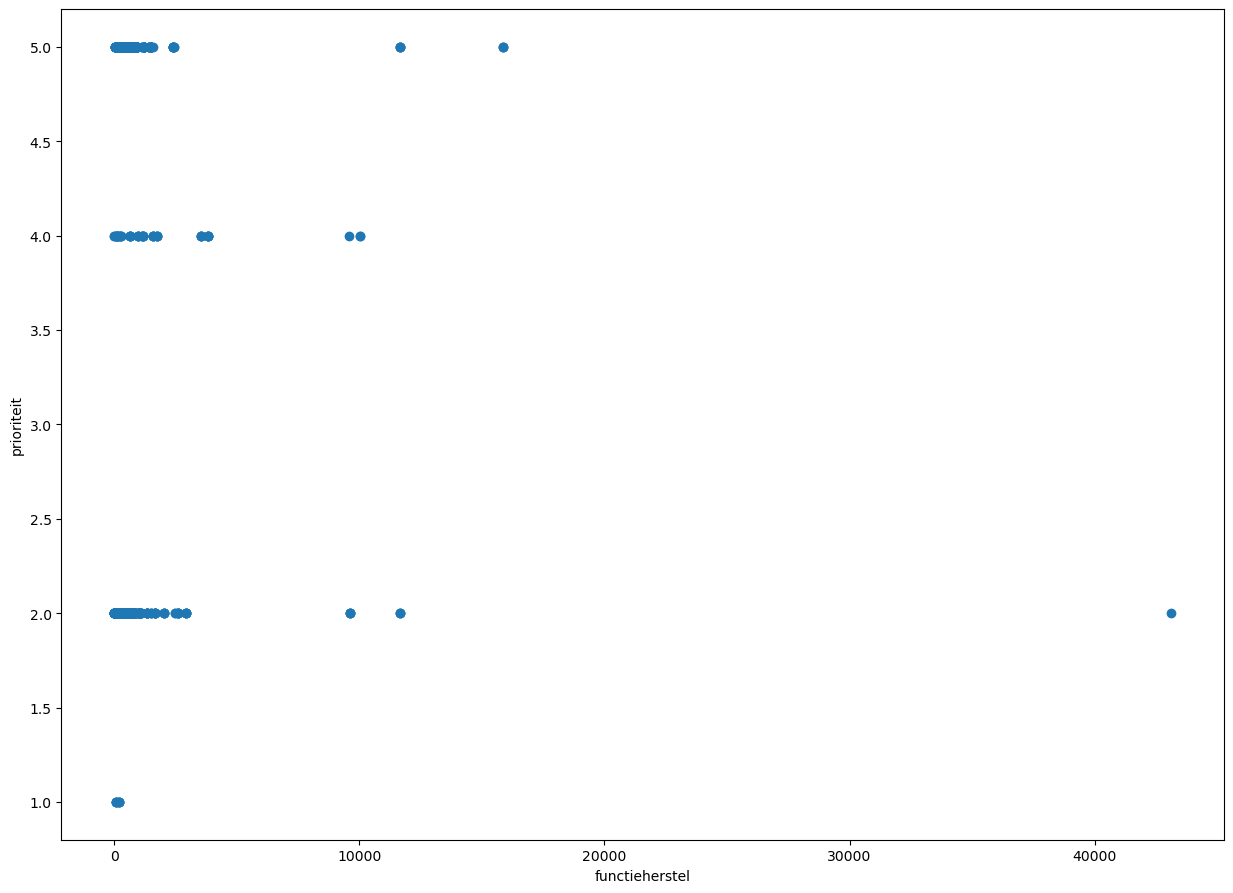

In [35]:
plt.figure(figsize=(15,11), dpi=100)
plt.scatter(functieherstel, prioriteit_feature, label="Scatter Plot")
plt.xlabel("functieherstel")
plt.ylabel("prioriteit")

We hebben ook snel naar de frequency gekeken van elk prioriteit welke het grootse modus had van alle prioriteiten.

<AxesSubplot:>

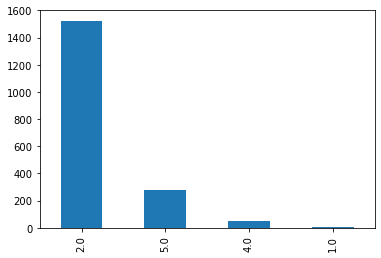

In [57]:
prioriteit_feature.value_counts().plot(kind='bar')

### Conclusie -  prioriteit

we kunnen een conclusie trekken dat de prioriteit feature wel wat over de functiehersteltijd zegt. maar dat er wel weinig gevallen waren waar de functieherstel best lang was. we zien wel uit de onderzoek dat een prioriteit van 1 altijd een functiehersteltijd heeft van 0 wat wilt zeggen dat elke probleem met die prioriteit altijd zowat is opgelost. we kunnnen aannemen dat dat best groot effect heeft op de functie herstel dan de andere prioriteiten. 

### Feature variable - oorzaakcode

We konden vooral niet zien of er een trend was binnen het data waarom somige oorzaak codes een langere functie herstel hadden dan andere. Daarom gaan we proberen of we bepaalde oorzaak codes kunnen groeperen zodat we meer algemener kunnen praten over een bepaald storing groep en daar een uitspraak kunnen maken over de functie herstel van die groep.


Text(0, 0.5, 'oorzaak_code')

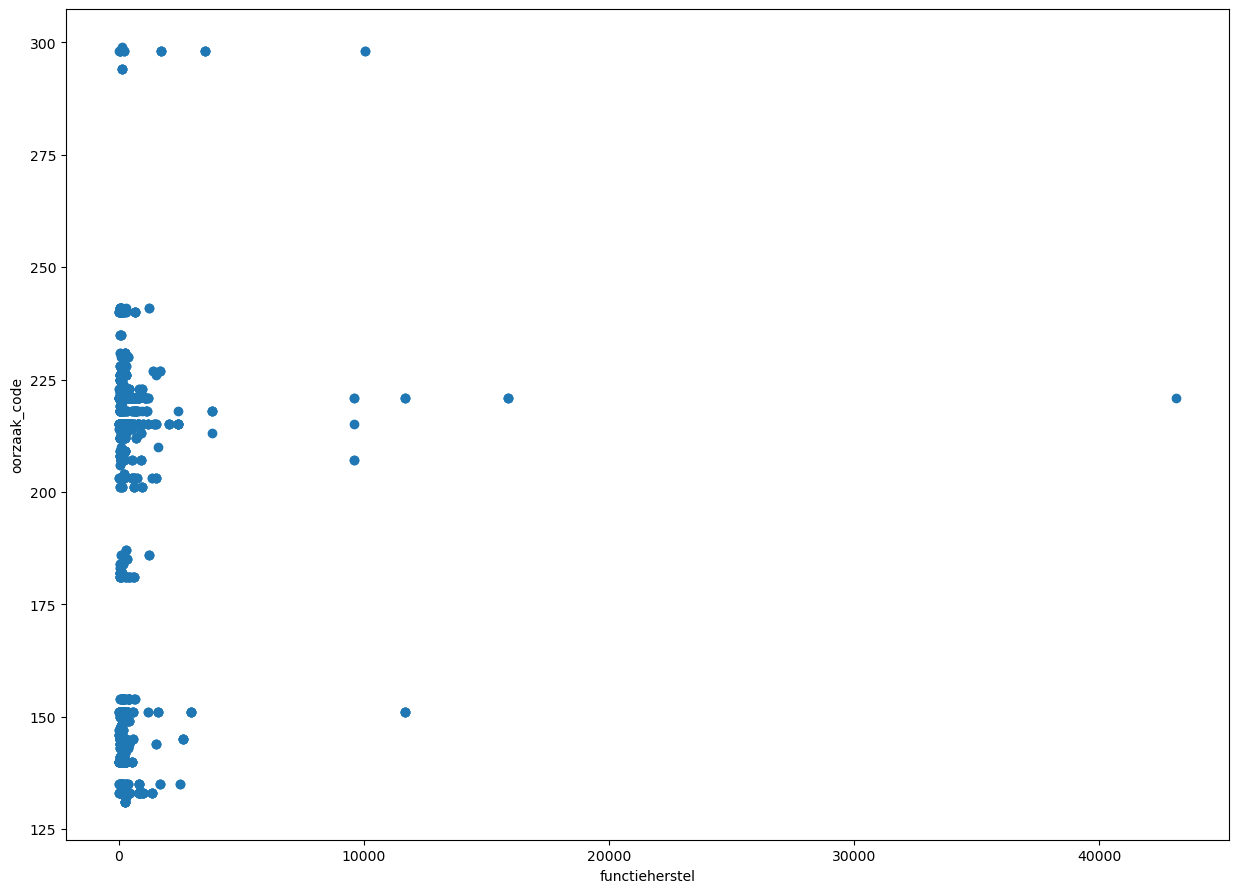

In [33]:
plt.figure(figsize=(15,11), dpi=100)
plt.scatter(functieherstel, oorzaakcode_feature, label="Scatter Plot")
plt.xlabel("functieherstel")
plt.ylabel("oorzaak_code")

We kunnen zien dat de oorzaak groep (TECHONV) de grootse frequentie heeft kwa oorzaak groep binnen het dataframe. We kunnen hier op verder kijken of dit oorzaak groep ook het grootse functieherstel tijd heeft dan andere oorzaakgroepen.

In [18]:
oorzaak_groep = pd.DataFrame(df, columns=["stm_oorz_code", "stm_oorz_groep", "stm_fh_duur"])

<AxesSubplot:>

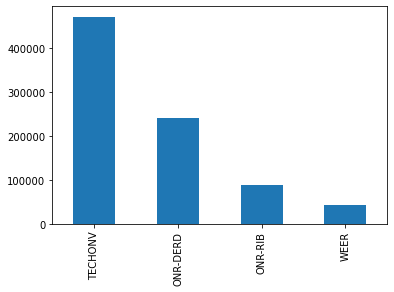

In [19]:
oorzaak_groep['stm_oorz_groep'].value_counts().plot(kind='bar')

In [20]:
TECHONV = oorzaak_groep[oorzaak_groep.stm_oorz_groep == 'TECHONV']
ONR_DERD = oorzaak_groep[oorzaak_groep.stm_oorz_groep == 'ONR-DERD']
ONR_RIB = oorzaak_groep[oorzaak_groep.stm_oorz_groep == 'ONR-RIB']
WEER = oorzaak_groep[oorzaak_groep.stm_oorz_groep == 'WEER']

We kunnen hier onder in de plot zien dat de oorzaak groep (TECHONV) veel meer data punten heeft bij een hogere functie herstel wat wilt zeggen dat algemeen binnen dat groep een oorzaak code een langere functie herstel heeft dan andere oorzaak codes binnen groepen

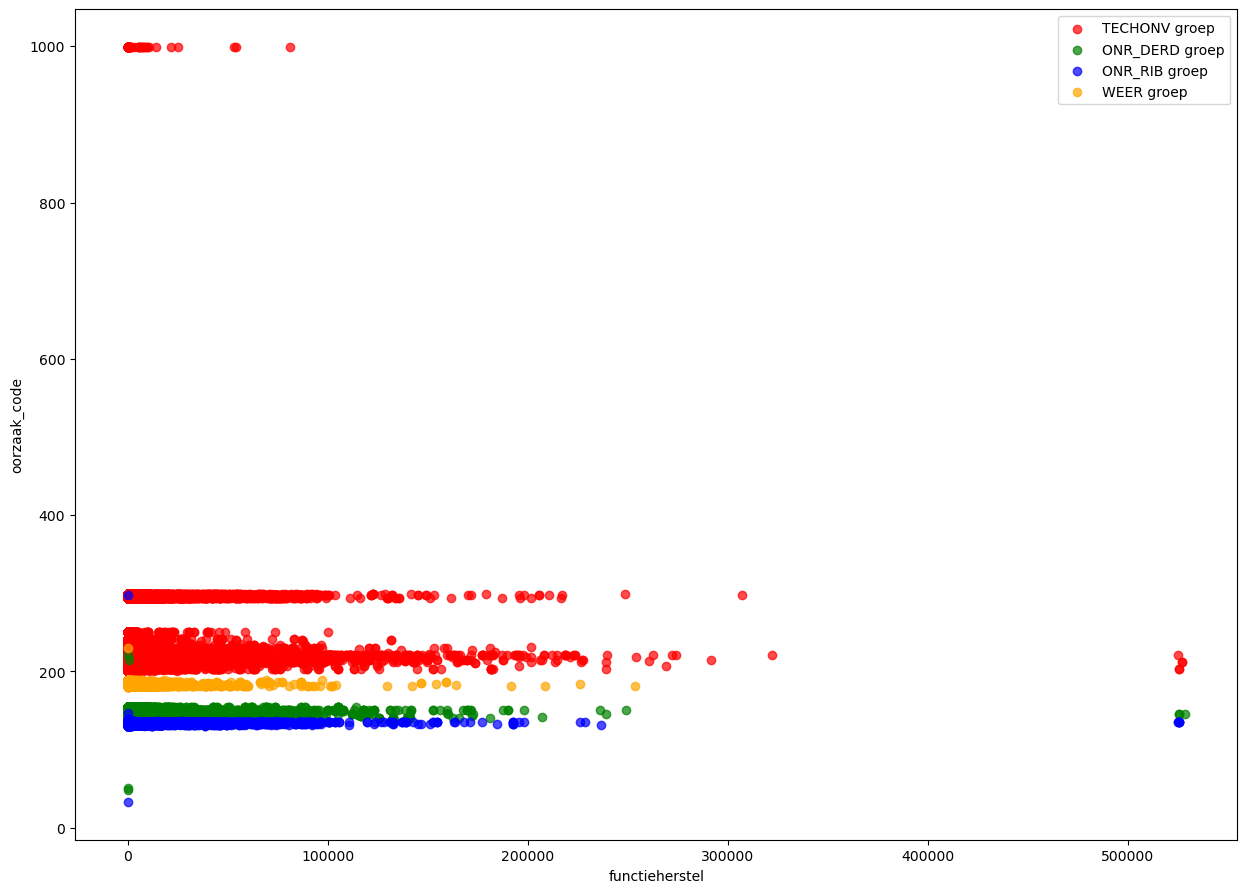

In [34]:
plt.figure(figsize=(15,11), dpi=100)
plt.scatter(TECHONV["stm_fh_duur"], TECHONV["stm_oorz_code"], label="TECHONV groep", color="r", alpha=.7)
plt.scatter(ONR_DERD["stm_fh_duur"], ONR_DERD["stm_oorz_code"], label="ONR_DERD groep", color="g", alpha=.7)
plt.scatter(ONR_RIB["stm_fh_duur"], ONR_RIB["stm_oorz_code"], label="ONR_RIB groep", color="b", alpha=.7)
plt.scatter(WEER["stm_fh_duur"], WEER["stm_oorz_code"], label="WEER groep", color="orange", alpha=.7)
plt.xlabel("functieherstel")
plt.ylabel("oorzaak_code")
plt.legend()

### Conclusie - oorzaakcode

We kunnen concluderen dat de feature variable oorzaakcode een matige feature variable is aangezien het wel nog wat over de functiehersteltijd wat zegt maar toch niet zwaar telt in het voorspellen van het tijd. dit kunnen we concluderen als we naar de plot hier boven kijken. we kunnen zien dat meerdere groepen het zelfde effect kunnen hebben op het functiehersteltijd inplaats van dat er verschillen zitten tussen groepen. hierbij word er aangetoond dat een specifiek groep geen zwaarder gewicht heeft dan een ander groep wat tot conclusie zegt dat er geen specifiek storing code is die algemener een zwaarder gewicht heeft dan een ander code.